In [58]:
import iris
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [59]:
def calc_normalized_anomalies(ds_prep, window_size=21):
    """
    This method prepares the input Dataset. It calculates the normalized anomalies with means
    and std calculated with a centered window of size window_size
    """

    # Resample with mean over data if temporal resolution is higher than daily (Lower resolution not supported here)
    if pd.infer_freq(ds_prep.time.data) not in 'D':
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})

    # calculates the climatology and the standard deviation for further anomaly calculation
    ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim') # creates the rolling window as a new dimension

    # calculate climatology (dayofyear mean) for rolling window over Target Day ± 10days (pool)
    # IMPORTANT DIFFERENCE:
    # mean rolling window before meaning time: all windows where at least one timestep is missing are dropped
    # ds_prep_clim_alt = ds_prep.rolling(time=window_size, center=True).mean().groupby('time.dayofyear').mean('time')

    # mean after construct with dropna: same as above (all windows, where at least one timestep is missing are dropped)
    # ds_prep_clim = ds_prep_roll.dropna('time').groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # mean after construct without dropna: first and last windows are considered, even if there are timesteps with missing values
    ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # calculate standard deviation (dayofyear std) for rolling window over Target Day ± 10days (pool)
    ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS) # Calculates the std for dayofyear of TD + pool, shape(365,)

    # calculate daily normalized anomalies with mean and std from TD + pool
    ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
    ds_prep = ds_prep.groupby('time.dayofyear') / ds_prep_std

    # Rechunking necessary after groupby
    ds_prep = ds_prep.chunk({'time': -1})

    return ds_prep

In [60]:
mslp_path = '/mnt/c/Users/susaw/Desktop/JRA-55_subsets/mslp/*.nc'
rh_path = '/mnt/c/Users/susaw/Desktop/JRA-55_subsets/rh/*.nc'
sh_path = '/mnt/c/Users/susaw/Desktop/JRA-55_subsets/sh/*.nc'

In [61]:
def read_data(path):
    data = xr.open_mfdataset(path)     # Daten werden als xarray Dataset eingelesen
    data = data.rename({'initial_time0_hours': 'time', 'g0_lat_1': 'lat', 'g0_lon_2': 'lon'}).drop('initial_time0_encoded')
    data.coords['lon'].data=(data.coords['lon']+180)%360-180
    if path == mslp_path:
        data = data.rename({'PRMSL_GDS0_MSL': 'mslp'})
    elif path == rh_path:
        data = data.rename({'RH_GDS0_ISBL':'rh'})
    else:
        data = data.rename({'SPFH_GDS0_ISBL':'sh'})
    return data

In [62]:
data=read_data(mslp_path)

In [63]:
data = calc_normalized_anomalies(data)
data_roll = data.rolling(time=21, center=True).construct('window_dim')

In [64]:
data.mslp

<xarray.DataArray 'mslp' (time: 1461, lat: 29, lon: 29)>
dask.array<shape=(1461, 29, 29), dtype=float32, chunksize=(1461, 29, 29)>
Coordinates:
  * lat        (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
    dayofyear  (time) int64 dask.array<shape=(1461,), chunksize=(1461,)>

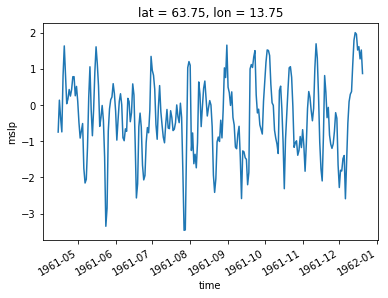

In [65]:
data.mslp[1200:1450,3,19].plot()

In [23]:
for _, ds_test in data_roll.groupby("time.dayofyear"):
    
    ds_test = ds_test.rename({"time":"time_old"})
    
    ds_test = ds_test.stack(time=('time_old','window_dim')).transpose('time','lat','lon')
    
    ds_test.coords['time'].attrs['axis'] = 'T'
    
    solver = Eof(ds_test.mslp.dropna('time'))
    pc = solver.pcs(npcs=5)
    eof = solver.eofs(neofs=5)
    
    break

In [57]:
pc

<xarray.DataArray 'pcs' (time: 74, mode: 5)>
array([[ 1.550875, 14.210485, -3.3861  ,  6.316097,  3.355529],
       [17.359562, 10.855576,  1.394468,  7.979644,  3.601041],
       [31.924273, -3.092365,  4.716172,  7.962531,  0.81118 ],
       ...,
       [-3.284582,  0.761078, -0.95845 ,  4.556196, -5.377714],
       [ 1.691367,  6.177955,  3.534039,  9.448521, -1.668437],
       [18.044186,  0.347641, -1.066386,  0.411781,  2.71082 ]], dtype=float32)
Coordinates:
  * time        (time) MultiIndex
  - time_old    (time) datetime64[ns] 1958-01-01 1958-01-01 ... 1959-01-01
  - window_dim  (time) int64 10 11 12 13 14 15 16 17 ... 11 12 13 14 15 16 17 18
  * mode        (mode) int64 0 1 2 3 4
    dayofyear   (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

In [36]:
lats = eof['lat'][:] 
lons = eof['lon'][:]

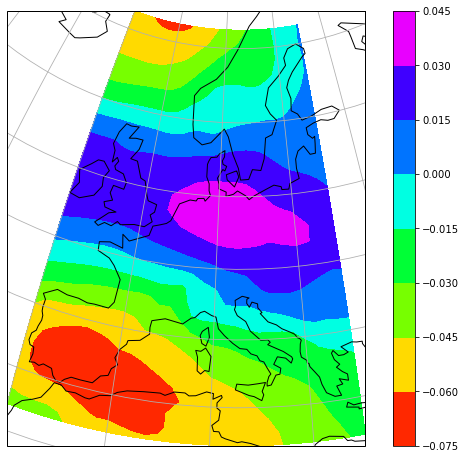

In [47]:
f=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=13,central_latitude=63))
c = ax.contourf(lons,lats,eof.values[4,:,:],transform=ccrs.PlateCarree(),cmap='gist_rainbow')
ax.coastlines()
ax.gridlines()
clb = plt.colorbar(c,ax=ax, orientation='vertical')